# Setup

In [126]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.datasets import imdb
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.utils import np_utils
import numpy as np
import h5py
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger


from sklearn.model_selection import train_test_split

In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

In [128]:
import math
import os
import pickle as pkl
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

# Functions

In [129]:
def calculate_precision_recall(model, X, y):
    """
    calulate precision, recall based on different thresholds
    :param X: pandas dataframe
    :param y: array of labels
    :return: dataframe of model_name, precision, recall, threshold
    """
    thresh_list = []
    precision_list = []
    recall_list = []

    predd = model.predict_proba(X)
    for my_threshold in range(500, 1000, 10):
        thres = my_threshold / 1000
        y_test_pred = (predd >= thres).argmax(axis=1)

        recall1 = round(recall_score(y, y_test_pred), 2)
        prec1 = round(precision_score(y, y_test_pred), 2)
        precision_list.append(prec1)
        recall_list.append(recall1)
        thresh_list.append(thres)

    df_threshold = pd.DataFrame(
        {'precision_fraud': precision_list, 'recall_fraud': recall_list,
         'threshold': thresh_list})
    return df_threshold

def report_optimal_threshold(model, X, y):
    """
    calulate the optimal threshold for balanced precision and recall
    :param X: pandas dataframe
    :param y: array of labels
    :return: float of optimal threshold
    """
    df_threshold = calculate_precision_recall(model, X, y)
    df_threshold['diff'] = np.abs(df_threshold['precision_fraud'] - df_threshold['recall_fraud'])
    optimal_threshold = df_threshold[df_threshold['diff'] == df_threshold['diff'].min()]['threshold'].values[0]
    return optimal_threshold

def calculate_precision_threshold(model, X, y):
    df_threshold = calculate_precision_recall(model, X, y)

    predd = model.predict_proba(X)
    list_of_met = []
    for i in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98]:
        df_threshold['prec_th'] = i
        list_of_met.append(df_threshold[df_threshold['precision_fraud'] >= i][:1])

    df_met = pd.concat(list_of_met)
    conf_matrix_all = [list(report_confusion_matrix(y, predd, threshold=prec_th)) for prec_th in
                       df_met['threshold']]
    df_res = pd.DataFrame(conf_matrix_all, \
                          columns=["NonFraud_ActualNonFraud", "Fraud_ActualNonFraud", "NonFraud_ActualFraud",
                                   "Fraud_ActualFraud"])

    df_met['Fraud_ActualFraud'] = df_res['Fraud_ActualFraud'].values
    df_met['Fraud_ActualNonFraud'] = df_res['Fraud_ActualNonFraud'].values
    df_met['NonFraud_ActualFraud'] = df_res['NonFraud_ActualFraud'].values
    df_met['NonFraud_ActualNonFraud'] = df_res['NonFraud_ActualNonFraud'].values

    df_met = df_met.reset_index(drop=True)
    return df_met


def report_confusion_matrix(y, y_pred_proba, threshold=0.5):
    """
    :param y: true labels
    :param y_pred_proba: predicted probability
    :param threshold: threshold of fraud
    :return: 1d numpy array of confusion matrix
    """
    y_pred = (y_pred_proba >= threshold).argmax(axis=1)
    confusion_mat = confusion_matrix(y, y_pred).ravel()
    return confusion_mat

def report_metrics(model, X, y, optimal_threshold=None, data_name=None):
    """
    calculate confusion matrix, roc_auc, precision and recall
    :param X: dataframe ready to predcit
    :param y: true labels
    :param data_name: string name of data (train, test)
    :return:
    """
    y_pred_proba = model.predict_proba(X)
    roc_score = roc_auc_score(y, y_pred_proba[:, 1], average="weighted")

    curr_threshold = 0.96
    conf_matrix_ = list(report_confusion_matrix(y, y_pred_proba, threshold=curr_threshold))
    conf_matrix_.append(curr_threshold)
    # threshold IsOptimal
    conf_matrix_.append(False)

    if not optimal_threshold:
        optimal_threshold = report_optimal_threshold(model, X, y)
    conf_matrix_optimal_th = list(report_confusion_matrix(y, y_pred_proba, threshold=optimal_threshold))
    conf_matrix_optimal_th.append(optimal_threshold)
    # threshold IsOptimal
    conf_matrix_optimal_th.append(True)

    df_res = pd.DataFrame([conf_matrix_, conf_matrix_optimal_th], \
                          columns=["NonFraud_ActualNonFraud", "Fraud_ActualNonFraud", \
                                   "NonFraud_ActualFraud", "Fraud_ActualFraud", \
                                   "threshold", "optimal_threshold"])
    df_res['roc_auc'] = roc_score
    df_res['data'] = data_name
    df_res['user_count'] = len(y)

    df_res['precision'] = df_res['Fraud_ActualFraud'] / (
            df_res['Fraud_ActualFraud'] + df_res['Fraud_ActualNonFraud'])
    df_res['recall'] = df_res['Fraud_ActualFraud'] / (df_res['Fraud_ActualFraud'] + df_res['NonFraud_ActualFraud'])
    df_res['f1_score'] = (2 * df_res['precision'] * df_res['recall']) / (df_res['precision'] + df_res['recall'])

    df_res = round(df_res, 3)
    df_res = df_res[['data', 'user_count', 'threshold', 'optimal_threshold', \
                     'roc_auc', 'precision', 'recall', 'f1_score', \
                     'Fraud_ActualFraud', 'Fraud_ActualNonFraud', 'NonFraud_ActualFraud',
                     'NonFraud_ActualNonFraud']]
    return df_res


def report_metric(model, x_train, y_train, x_test, y_test):
    train_report = report_metrics(model, x_train, y_train, data_name='train')
    opt_t=train_report[train_report['optimal_threshold'] ==True]['threshold'].values[0]
    test_report= report_metrics(model, x_test, y_test, optimal_threshold=opt_t, data_name='test')

    report = pd.concat([train_report, test_report])
    return report

In [130]:
def filter_correlated_features(df_merged_filtered):
    """
    filter correlated features for multicolinearity problem
    :param df_merged_filtered:
    :return: dataframe wxluded the correlated features
    """
    columns_keep = []
    for col in df_merged_filtered.columns:
        if df_merged_filtered[col].nunique() > 1:
            columns_keep.append(col)

    df_merged_filtered = df_merged_filtered[columns_keep]
    not_dummy = ['impression_col', 'session_click', 'session_dev', 'session_ip', 'session_post_back', \
                 'device_plat_unique_vals', 'profile_change_fieldid', 'question_diff_source', \
                 'survey_status_', 'ss1_provider_', 'ss1_provider_', 'ss2_provider_', 'ss3_provider_', \
                 'act_conv_rate_all_', 'success_rate_provider_', 'status_change_reasonid_', \
                 'session_length_minutes_', '_browser_unique_vals', 'avg_acloi_provider_', 'sum_acloi_provider_']

    pre_dummy_variables_to_add = [col for col in df_merged_filtered.columns if (
            (df_merged_filtered[col].nunique() == 2) & (~(("CLICK" in col) | ("BACK" in col))))]
    dummy_variables_to_add = [x for x in pre_dummy_variables_to_add if all(elem not in x for elem in not_dummy)]

    variables_to_filter = list(set(df_merged_filtered.columns).difference(set(dummy_variables_to_add)))

    df_temp = df_merged_filtered[variables_to_filter]
    # Create correlation matrix
    corr_matrix = df_temp.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.85
    to_drop = [column for column in upper.columns if any((upper[column] > 0.90))]
    print('dropping #features:', len(to_drop))
    df_temp = df_temp.drop(to_drop, axis=1)
    df_merged_filtered = pd.concat([df_temp, df_merged_filtered[dummy_variables_to_add]], axis=1)
    print('filtering correlated features done.')
    return df_merged_filtered


def adjust_features(_features, X):
    """
        adjust the features to the trained set (sequence and existence)
        :param X: pandas dataframe
        :return: adjusted dataframe
        """
    cols_to_add = set(_features).difference(set(X.columns))
    df_cols_to_add = pd.DataFrame(columns=cols_to_add)
    df_to_predict_ready = pd.concat([X, df_cols_to_add], axis=1).fillna(0)
    x_adjusted = df_to_predict_ready[_features]
    return x_adjusted

def standardize_data(df, scaler=None):
    """
    standardize data based on Z-score
    :param df:
    :return:
    """
    if scaler is None:
        print("scaler is none")
        scaler = StandardScaler()
        scaler.fit(df)
    df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)
    return df_scaled, scaler


# Data

In [140]:
# df_sj = pd.read_csv('../data/processed/sj.csv')
df_sj = pd.read_csv('../data/processed/sj_oct.csv')

In [141]:
# columns = df_sj.columns[~df_sj.columns.str.contains('__')]
# columns = columns[~columns.str.contains('session')]
# columns = columns[~columns.str.contains('first_status|profile_|provider_id_|_provider_|status_change_')]

# df_sj = df_sj[columns]

----

In [142]:
X = df_sj.loc[:, ~df_sj.columns.isin(["user_id", "fraud"])]
y = df_sj['fraud'].values
X = X.replace(math.inf, 0)
x_train_raw, x_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41)

In [143]:

x_train_filt = filter_correlated_features(x_train_raw)
x_train, scaler = standardize_data(x_train_filt)

x_test_filt = adjust_features(x_train.columns, x_test_raw)
x_test, _ = standardize_data(x_test_filt, scaler)

dropping #features: 238
filtering correlated features done.
scaler is none


/Users/gasia/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gasia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/gasia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [144]:
def fit_logistic_regression(x_train, y_train, penalty_v = "l1", C_value = 0.01, \
                            GridSearch = False, max_iter = 1000):
    
    pars = {"random_state": 42, "class_weight": "balanced", "n_jobs": -1, "solver": "saga", "max_iter": 10000,
               "C": C_value, "verbose": 0, 'penalty': penalty_v}
    lr_model = LogisticRegression(**pars)
    
    if GridSearch:
        parameters = {"C": [0.001, 0.01, 0.1, 1], 'penalty':['l1', 'l2']}
        model_logit = GridSearchCV(lr_model, parameters, scoring="roc_auc", cv=None, verbose=5,
                                   pre_dispatch=20, return_train_score=True, n_jobs=-1)

        model_logit.fit(x_train,y_train)
        print("GridSearch best parameters: {}".format(model_logit.best_params_))
        
        C_value = model_logit.best_params_['C']
        penalty_v = model_logit.best_params_['penalty']
    
        pars = {"random_state": 42, "class_weight": "balanced", "n_jobs": -1, "solver": "saga", "max_iter": 10000,
                   "C": C_value, "verbose": 0, 'penalty': penalty_v}
        lr_model = LogisticRegression(**pars)
    
    lr_model.fit(x_train,y_train)
    return lr_model

In [145]:
def fit_decision_tree(x_train, y_train, criterion='entropy', max_depth=5, min_samples_leaf=20, GridSearch=False):
    
    dt_model = DecisionTreeClassifier(random_state=42, max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf, class_weight="balanced")
    
    if GridSearch:
        parameters = dict(max_depth=list(range(3,7,1)), min_samples_leaf = list(range(5,41,5)),
                         criterion  = ['gini', 'entropy'])
        model_tree = GridSearchCV(dt_model, parameters, scoring='roc_auc', cv=3,verbose=5)

        model_tree.fit(x_train,y_train)
        print(model_tree.best_params_)
        max_depth=model_tree.best_params_["max_depth"]
        min_samples_leaf=model_tree.best_params_["min_samples_leaf"]
        criterion = model_tree.best_params_["criterion"]
        
        dt_model = DecisionTreeClassifier(random_state=42, max_depth=max_depth, criterion =criterion,
                                        min_samples_leaf=min_samples_leaf, class_weight="balanced")
    
    dt_model.fit(x_train,y_train)
    return dt_model

In [146]:
def fit_random_forest(x_train, y_train, max_depth=10, min_samples_leaf=20, n_estimators = 10,
                      GridSearch=False):
    
    rf_model = RandomForestClassifier(random_state=42, max_depth=max_depth,n_jobs = -1, n_estimators=n_estimators,
                                        min_samples_leaf=min_samples_leaf, class_weight="balanced")

    if GridSearch:
        parameters = dict(max_depth=list(range(2,7,1)), min_samples_leaf = list(range(1,40,3)),
                         n_estimators=list(range(10,100,20)))
        model_rf = GridSearchCV(rf_model, parameters, scoring='roc_auc', verbose=5)

        model_rf.fit(x_train,y_train)
        print(model_rf.best_params_)
        max_depth=model_rf.best_params_["max_depth"]
        min_samples_leaf=model_rf.best_params_["min_samples_leaf"]
        n_estimators=model_rf.best_params_["n_estimators"]
        
        rf_model = RandomForestClassifier(random_state=42, max_depth=max_depth,n_estimators=n_estimators,
                                        min_samples_leaf=min_samples_leaf, class_weight="balanced")
    
    rf_model.fit(x_train,y_train)
    return rf_model

In [147]:
def fit_naive_bayes(x_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(x_train, y_train)
    return nb_model

----

In [120]:
#GridSearch best parameters: {'C': 0.1, 'penalty': 'l1'}
logistic_regression = fit_logistic_regression(x_train, y_train,  penalty_v = "l1", C_value = 0.01)
report_metric(logistic_regression, x_train, y_train, x_test, y_test)

/Users/gasia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,data,user_count,threshold,optimal_threshold,roc_auc,precision,recall,f1_score,Fraud_ActualFraud,Fraud_ActualNonFraud,NonFraud_ActualFraud,NonFraud_ActualNonFraud
0,train,9732,0.96,False,0.947,0.960,0.229,0.369,796,33,2684,6219
1,train,9732,0.53,True,0.947,0.896,0.902,0.899,3139,365,341,5887
0,test,2434,0.96,False,0.941,0.938,0.233,0.373,196,13,646,1579
1,test,2434,0.53,True,0.941,0.877,0.909,0.893,765,107,77,1485


In [121]:
x_train.columns

Index(['impression_col_row_5.0_11.0', 'acloi_aloi_ratio_sum',
       'impression_col_row_6.0_12.0', 'impression_col_row_8.0_6.0',
       'impression_row_map_6.0', 'activity_calculated_loi_1-5min_rel',
       'activity_loi_11-15min_rel', 'rev_points_0_0.5', 'first_name_len',
       'device_platform_Smart-TV',
       ...
       'affiliate_596', 'affiliate_630', 'affiliate_805', 'affiliate_980',
       'signup_source_id_1', 'signup_source_id_2', 'signup_source_id_3',
       'device_platform_Other Mobile', 'device_platform_Robot',
       'impression_row_map_0.0'],
      dtype='object', length=300)

In [122]:
t = pd.DataFrame( x_train.columns)

In [123]:
t['c'] = logistic_regression.coef_[0]

In [124]:
t.sort_values('c')

,0,c
167,internal_act,-0.742017
10,user_click_back_rate,-0.450592
5,activity_calculated_loi_1-5min_rel,-0.317365
125,points_4-35_rel,-0.269719
214,ManualVerificationMandated_8.0,-0.119819
...,...,...
143,impression_col_row_3.0_3.0,0.107581
208,FinalIdentityVerificationIsPermanentlyVerified...,0.127167
105,survey_ratio,0.169535
135,rev_points_sum,0.248837


In [47]:
#{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 20}

# no session{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 20}
decision_tree = fit_decision_tree(x_train, y_train,  criterion='entropy', max_depth=5, min_samples_leaf= 20, 
                                  GridSearch=True)

report_metric(decision_tree, x_train, y_train, x_test, y_test)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] criterion=gini, max_depth=3, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=5, score=0.9315507313521741, total=   0.2s
[CV] criterion=gini, max_depth=3, min_samples_leaf=5 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_leaf=5, score=0.9342345621814813, total=   0.2s
[CV] criterion=gini, max_depth=3, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=5, score=0.9443498080614204, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_leaf=10 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_leaf=10, score=0.9315507313521741, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_leaf=10 ................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=10, score=0.9342345621814813, total=   0.2s
[CV] criterion=gini, max_depth=3, min_samples_leaf=10 ................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_leaf=10, score=0.9443498080614204, total=   0.2s
[CV] criterion=gini, max_depth=3, min_samples_leaf=15 ................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=15, score=0.9315507313521741, total=   0.2s
[CV] criterion=gini, max_depth=3, min_samples_leaf=15 ................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=15, score=0.9342345621814813, total=   0.2s
[CV] criterion=gini, max_depth=3, min_samples_leaf=15 ................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=15, score=0.9443498080614204, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=20, score=0.9315072969753126, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=20, score=0.9342345621814813, total=   0.2s
[CV] criterion=gini, max_depth=3, min_samples_leaf=20 ...............

[CV]  criterion=gini, max_depth=5, min_samples_leaf=15, score=0.9440476288966839, total=   0.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=15 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=15, score=0.9424866801244292, total=   0.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=20, score=0.9486951072208617, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=20, score=0.9464907091799589, total=   0.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=20, score=0.9453531421669205, total=   0.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=25 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=25, score=0.9471589780925276, total=   0.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=25 ...............

[CV]  criterion=entropy, max_depth=3, min_samples_leaf=20, score=0.942748941028526, total=   0.2s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=20, score=0.9360947944933482, total=   0.2s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=20, score=0.9468994059831889, total=   0.2s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=25 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=25, score=0.9400919981467999, total=   0.2s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=25 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=25, score=0.9339218346680784, total=   0.2s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=25 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=25, score=0.945192228142167, total=   0.2s
[CV] criterion=entropy, max_depth=3, min_samples_leaf

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=20, score=0.9483726586802568, total=   0.2s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=20, score=0.9503919435435834, total=   0.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=25 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=25, score=0.9522447299622742, total=   0.2s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=25 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=25, score=0.9471196803229863, total=   0.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=25 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=25, score=0.9487877672248329, total=   0.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, score=0.9519657157985307, total=   0.2s
[CV] criterion=entropy, max_depth=5, min_samples_le

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   44.7s finished


{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 20}


,data,user_count,threshold,optimal_threshold,roc_auc,precision,recall,f1_score,Fraud_ActualFraud,Fraud_ActualNonFraud,NonFraud_ActualFraud,NonFraud_ActualNonFraud
0,train,9732,0.96,False,0.961,0.991,0.647,0.783,2252,21,1228,6231
1,train,9732,0.50,True,0.961,0.909,0.895,0.902,3113,313,367,5939
0,test,2434,0.96,False,0.947,0.988,0.660,0.791,556,7,286,1585
1,test,2434,0.50,True,0.947,0.880,0.894,0.887,753,103,89,1489


In [139]:
#{'max_depth': 6, 'min_samples_leaf': 7, 'n_estimators': 90}
# no session{'max_depth': 6, 'min_samples_leaf': 1, 'n_estimators': 90}
random_forest = fit_random_forest(x_train, y_train, GridSearch=False, max_depth= 6, min_samples_leaf= 1, n_estimators=90)
report_metric(random_forest, x_train, y_train, x_test, y_test)

Fitting 3 folds for each of 325 candidates, totalling 975 fits
[CV] max_depth=2, min_samples_leaf=1, n_estimators=10 ................


/Users/gasia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=2, min_samples_leaf=1, n_estimators=10, score=0.9306903170295849, total=   1.8s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=10 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=1, n_estimators=10, score=0.9285262509100537, total=   0.7s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=10 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=1, n_estimators=10, score=0.9305172000132372, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=30 ................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=1, n_estimators=30, score=0.9367959494341122, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=30 ................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.4s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=1, n_estimators=30, score=0.9343727248659739, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=30 ................
[CV]  max_depth=2, min_samples_leaf=1, n_estimators=30, score=0.9350935286915085, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=50 ................
[CV]  max_depth=2, min_samples_leaf=1, n_estimators=50, score=0.9358954100205176, total=   0.3s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=50 ................
[CV]  max_depth=2, min_samples_leaf=1, n_estimators=50, score=0.9344846200939837, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=50 ................
[CV]  max_depth=2, min_samples_leaf=1, n_estimators=50, score=0.9352552700377259, total=   0.2s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=70 ................
[CV]  max_depth=2, min_samples_leaf=1, n_estimators=70, score=0.9367905718445959, total=   0.3s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=70 ...............

[CV]  max_depth=2, min_samples_leaf=10, n_estimators=70, score=0.9367653385399433, total=   0.3s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=70 ...............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=70, score=0.9363196191011978, total=   0.3s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=70 ...............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=70, score=0.9367289363955258, total=   0.3s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=90 ...............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=90, score=0.9366834337150043, total=   0.3s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=90 ...............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=90, score=0.9358976851545436, total=   0.3s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=90 ...............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=90, score=0.937290687669601, total=   0.3s
[CV] max_depth=2, min_samples_leaf=13, n_estimators=10 .........

[CV]  max_depth=2, min_samples_leaf=19, n_estimators=90, score=0.9356962323780528, total=   0.3s
[CV] max_depth=2, min_samples_leaf=19, n_estimators=90 ...............
[CV]  max_depth=2, min_samples_leaf=19, n_estimators=90, score=0.9371227414124033, total=   0.3s
[CV] max_depth=2, min_samples_leaf=22, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_leaf=22, n_estimators=10, score=0.9309503027996557, total=   0.2s
[CV] max_depth=2, min_samples_leaf=22, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_leaf=22, n_estimators=10, score=0.9285262509100537, total=   0.2s
[CV] max_depth=2, min_samples_leaf=22, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_leaf=22, n_estimators=10, score=0.9305428469786221, total=   0.2s
[CV] max_depth=2, min_samples_leaf=22, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_leaf=22, n_estimators=30, score=0.9368652376067245, total=   0.2s
[CV] max_depth=2, min_samples_leaf=22, n_estimators=30 ........

[CV]  max_depth=2, min_samples_leaf=31, n_estimators=10, score=0.9305445016215501, total=   0.2s
[CV] max_depth=2, min_samples_leaf=31, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_leaf=31, n_estimators=30, score=0.9368652376067245, total=   0.2s
[CV] max_depth=2, min_samples_leaf=31, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_leaf=31, n_estimators=30, score=0.9339125273016082, total=   0.2s
[CV] max_depth=2, min_samples_leaf=31, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_leaf=31, n_estimators=30, score=0.9337265868025681, total=   0.2s
[CV] max_depth=2, min_samples_leaf=31, n_estimators=50 ...............
[CV]  max_depth=2, min_samples_leaf=31, n_estimators=50, score=0.9358894119399034, total=   0.3s
[CV] max_depth=2, min_samples_leaf=31, n_estimators=50 ...............
[CV]  max_depth=2, min_samples_leaf=31, n_estimators=50, score=0.9341255625785956, total=   0.3s
[CV] max_depth=2, min_samples_leaf=31, n_estimators=50 ........

[CV]  max_depth=3, min_samples_leaf=1, n_estimators=50, score=0.9404955241908796, total=   0.3s
[CV] max_depth=3, min_samples_leaf=1, n_estimators=50 ................
[CV]  max_depth=3, min_samples_leaf=1, n_estimators=50, score=0.9378499569792839, total=   0.3s
[CV] max_depth=3, min_samples_leaf=1, n_estimators=50 ................
[CV]  max_depth=3, min_samples_leaf=1, n_estimators=50, score=0.9395418293732213, total=   0.3s
[CV] max_depth=3, min_samples_leaf=1, n_estimators=70 ................
[CV]  max_depth=3, min_samples_leaf=1, n_estimators=70, score=0.9401424647561056, total=   0.3s
[CV] max_depth=3, min_samples_leaf=1, n_estimators=70 ................
[CV]  max_depth=3, min_samples_leaf=1, n_estimators=70, score=0.9385262922761267, total=   0.3s
[CV] max_depth=3, min_samples_leaf=1, n_estimators=70 ................
[CV]  max_depth=3, min_samples_leaf=1, n_estimators=70, score=0.9396760622807598, total=   0.3s
[CV] max_depth=3, min_samples_leaf=1, n_estimators=90 ...............

[CV]  max_depth=3, min_samples_leaf=10, n_estimators=70, score=0.9400113343040573, total=   0.3s
[CV] max_depth=3, min_samples_leaf=10, n_estimators=90 ...............
[CV]  max_depth=3, min_samples_leaf=10, n_estimators=90, score=0.9402810411013304, total=   0.3s
[CV] max_depth=3, min_samples_leaf=10, n_estimators=90 ...............
[CV]  max_depth=3, min_samples_leaf=10, n_estimators=90, score=0.9390367496194321, total=   0.3s
[CV] max_depth=3, min_samples_leaf=10, n_estimators=90 ...............
[CV]  max_depth=3, min_samples_leaf=10, n_estimators=90, score=0.9404632586537824, total=   0.3s
[CV] max_depth=3, min_samples_leaf=13, n_estimators=10 ...............
[CV]  max_depth=3, min_samples_leaf=13, n_estimators=10, score=0.9363403021377986, total=   0.2s
[CV] max_depth=3, min_samples_leaf=13, n_estimators=10 ...............
[CV]  max_depth=3, min_samples_leaf=13, n_estimators=10, score=0.9295281372029917, total=   0.2s
[CV] max_depth=3, min_samples_leaf=13, n_estimators=10 ........

[CV]  max_depth=3, min_samples_leaf=22, n_estimators=10, score=0.9368646171156264, total=   0.2s
[CV] max_depth=3, min_samples_leaf=22, n_estimators=10 ...............
[CV]  max_depth=3, min_samples_leaf=22, n_estimators=10, score=0.9297422066318088, total=   0.2s
[CV] max_depth=3, min_samples_leaf=22, n_estimators=10 ...............
[CV]  max_depth=3, min_samples_leaf=22, n_estimators=10, score=0.93779680157522, total=   0.2s
[CV] max_depth=3, min_samples_leaf=22, n_estimators=30 ...............
[CV]  max_depth=3, min_samples_leaf=22, n_estimators=30, score=0.9398144317956185, total=   0.2s
[CV] max_depth=3, min_samples_leaf=22, n_estimators=30 ...............
[CV]  max_depth=3, min_samples_leaf=22, n_estimators=30, score=0.937262972400556, total=   0.2s
[CV] max_depth=3, min_samples_leaf=22, n_estimators=30 ...............
[CV]  max_depth=3, min_samples_leaf=22, n_estimators=30, score=0.9392803957905883, total=   0.2s
[CV] max_depth=3, min_samples_leaf=22, n_estimators=50 ...........

[CV]  max_depth=3, min_samples_leaf=31, n_estimators=30, score=0.9370346316764842, total=   0.2s
[CV] max_depth=3, min_samples_leaf=31, n_estimators=30 ...............
[CV]  max_depth=3, min_samples_leaf=31, n_estimators=30, score=0.9391577453835462, total=   0.3s
[CV] max_depth=3, min_samples_leaf=31, n_estimators=50 ...............
[CV]  max_depth=3, min_samples_leaf=31, n_estimators=50, score=0.9401995499371235, total=   0.3s
[CV] max_depth=3, min_samples_leaf=31, n_estimators=50 ...............
[CV]  max_depth=3, min_samples_leaf=31, n_estimators=50, score=0.9377405437156662, total=   0.3s
[CV] max_depth=3, min_samples_leaf=31, n_estimators=50 ...............
[CV]  max_depth=3, min_samples_leaf=31, n_estimators=50, score=0.9395705787940963, total=   0.3s
[CV] max_depth=3, min_samples_leaf=31, n_estimators=70 ...............
[CV]  max_depth=3, min_samples_leaf=31, n_estimators=70, score=0.9398473178238137, total=   0.3s
[CV] max_depth=3, min_samples_leaf=31, n_estimators=70 ........

[CV]  max_depth=4, min_samples_leaf=1, n_estimators=50, score=0.9451260424250446, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, n_estimators=70 ................
[CV]  max_depth=4, min_samples_leaf=1, n_estimators=70, score=0.9431259927857567, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, n_estimators=70 ................
[CV]  max_depth=4, min_samples_leaf=1, n_estimators=70, score=0.9416366073201402, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, n_estimators=70 ................
[CV]  max_depth=4, min_samples_leaf=1, n_estimators=70, score=0.9454211893573367, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, n_estimators=90 ................
[CV]  max_depth=4, min_samples_leaf=1, n_estimators=90, score=0.9433241362763914, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, n_estimators=90 ................
[CV]  max_depth=4, min_samples_leaf=1, n_estimators=90, score=0.9413135382884372, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, n_estimators=90 ...............

[CV]  max_depth=4, min_samples_leaf=10, n_estimators=90, score=0.9426054007545173, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, n_estimators=90 ...............
[CV]  max_depth=4, min_samples_leaf=10, n_estimators=90, score=0.9440269458600833, total=   0.3s
[CV] max_depth=4, min_samples_leaf=13, n_estimators=10 ...............
[CV]  max_depth=4, min_samples_leaf=13, n_estimators=10, score=0.9414078529353366, total=   0.2s
[CV] max_depth=4, min_samples_leaf=13, n_estimators=10 ...............
[CV]  max_depth=4, min_samples_leaf=13, n_estimators=10, score=0.9362292342312528, total=   0.2s
[CV] max_depth=4, min_samples_leaf=13, n_estimators=10 ...............
[CV]  max_depth=4, min_samples_leaf=13, n_estimators=10, score=0.9400866205572838, total=   0.2s
[CV] max_depth=4, min_samples_leaf=13, n_estimators=30 ...............
[CV]  max_depth=4, min_samples_leaf=13, n_estimators=30, score=0.9439175325964657, total=   0.3s
[CV] max_depth=4, min_samples_leaf=13, n_estimators=30 ........

[CV]  max_depth=4, min_samples_leaf=22, n_estimators=10, score=0.9389004484082335, total=   0.2s
[CV] max_depth=4, min_samples_leaf=22, n_estimators=30 ...............
[CV]  max_depth=4, min_samples_leaf=22, n_estimators=30, score=0.9434414090939175, total=   0.3s
[CV] max_depth=4, min_samples_leaf=22, n_estimators=30 ...............
[CV]  max_depth=4, min_samples_leaf=22, n_estimators=30, score=0.9406148653120656, total=   0.3s
[CV] max_depth=4, min_samples_leaf=22, n_estimators=30 ...............
[CV]  max_depth=4, min_samples_leaf=22, n_estimators=30, score=0.9427139866966708, total=   0.3s
[CV] max_depth=4, min_samples_leaf=22, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_leaf=22, n_estimators=50, score=0.9437677874114767, total=   0.4s
[CV] max_depth=4, min_samples_leaf=22, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_leaf=22, n_estimators=50, score=0.9414868621351512, total=   0.4s
[CV] max_depth=4, min_samples_leaf=22, n_estimators=50 ........

[CV]  max_depth=4, min_samples_leaf=31, n_estimators=50, score=0.9441617992587199, total=   0.3s
[CV] max_depth=4, min_samples_leaf=31, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_leaf=31, n_estimators=50, score=0.9409259381825402, total=   0.4s
[CV] max_depth=4, min_samples_leaf=31, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_leaf=31, n_estimators=50, score=0.943775440135019, total=   0.4s
[CV] max_depth=4, min_samples_leaf=31, n_estimators=70 ...............
[CV]  max_depth=4, min_samples_leaf=31, n_estimators=70, score=0.9436925011582501, total=   0.4s
[CV] max_depth=4, min_samples_leaf=31, n_estimators=70 ...............
[CV]  max_depth=4, min_samples_leaf=31, n_estimators=70, score=0.9421400324310014, total=   0.4s
[CV] max_depth=4, min_samples_leaf=31, n_estimators=70 ...............
[CV]  max_depth=4, min_samples_leaf=31, n_estimators=70, score=0.9438190813422463, total=   0.4s
[CV] max_depth=4, min_samples_leaf=31, n_estimators=90 .........

[CV]  max_depth=5, min_samples_leaf=1, n_estimators=70, score=0.9455835511946521, total=   0.4s
[CV] max_depth=5, min_samples_leaf=1, n_estimators=70 ................
[CV]  max_depth=5, min_samples_leaf=1, n_estimators=70, score=0.9473819412270831, total=   0.4s
[CV] max_depth=5, min_samples_leaf=1, n_estimators=90 ................
[CV]  max_depth=5, min_samples_leaf=1, n_estimators=90, score=0.9477118356608644, total=   0.4s
[CV] max_depth=5, min_samples_leaf=1, n_estimators=90 ................
[CV]  max_depth=5, min_samples_leaf=1, n_estimators=90, score=0.9458613243761997, total=   0.4s
[CV] max_depth=5, min_samples_leaf=1, n_estimators=90 ................
[CV]  max_depth=5, min_samples_leaf=1, n_estimators=90, score=0.9476942550797538, total=   0.4s
[CV] max_depth=5, min_samples_leaf=4, n_estimators=10 ................
[CV]  max_depth=5, min_samples_leaf=4, n_estimators=10, score=0.9449833294724999, total=   0.2s
[CV] max_depth=5, min_samples_leaf=4, n_estimators=10 ...............

[CV]  max_depth=5, min_samples_leaf=13, n_estimators=10, score=0.9444352290025814, total=   0.2s
[CV] max_depth=5, min_samples_leaf=13, n_estimators=10 ...............
[CV]  max_depth=5, min_samples_leaf=13, n_estimators=10, score=0.9408063902309882, total=   0.2s
[CV] max_depth=5, min_samples_leaf=13, n_estimators=10 ...............
[CV]  max_depth=5, min_samples_leaf=13, n_estimators=10, score=0.9409102190747236, total=   0.2s
[CV] max_depth=5, min_samples_leaf=13, n_estimators=30 ...............
[CV]  max_depth=5, min_samples_leaf=13, n_estimators=30, score=0.9463887418095175, total=   0.4s
[CV] max_depth=5, min_samples_leaf=13, n_estimators=30 ...............
[CV]  max_depth=5, min_samples_leaf=13, n_estimators=30, score=0.9435311734727646, total=   0.4s
[CV] max_depth=5, min_samples_leaf=13, n_estimators=30 ...............
[CV]  max_depth=5, min_samples_leaf=13, n_estimators=30, score=0.9481250827321464, total=   0.3s
[CV] max_depth=5, min_samples_leaf=13, n_estimators=50 ........

[CV]  max_depth=5, min_samples_leaf=22, n_estimators=30, score=0.9454668988682242, total=   0.4s
[CV] max_depth=5, min_samples_leaf=22, n_estimators=30 ...............
[CV]  max_depth=5, min_samples_leaf=22, n_estimators=30, score=0.9481556936263154, total=   0.3s
[CV] max_depth=5, min_samples_leaf=22, n_estimators=50 ...............
[CV]  max_depth=5, min_samples_leaf=22, n_estimators=50, score=0.9459517092461447, total=   0.3s
[CV] max_depth=5, min_samples_leaf=22, n_estimators=50 ...............
[CV]  max_depth=5, min_samples_leaf=22, n_estimators=50, score=0.9456995830299821, total=   0.4s
[CV] max_depth=5, min_samples_leaf=22, n_estimators=50 ...............
[CV]  max_depth=5, min_samples_leaf=22, n_estimators=50, score=0.948024356343901, total=   0.4s
[CV] max_depth=5, min_samples_leaf=22, n_estimators=70 ...............
[CV]  max_depth=5, min_samples_leaf=22, n_estimators=70, score=0.9461641240320339, total=   0.4s
[CV] max_depth=5, min_samples_leaf=22, n_estimators=70 .........

[CV]  max_depth=5, min_samples_leaf=31, n_estimators=50, score=0.9478088391025218, total=   0.4s
[CV] max_depth=5, min_samples_leaf=31, n_estimators=70 ...............
[CV]  max_depth=5, min_samples_leaf=31, n_estimators=70, score=0.9457310212456151, total=   0.4s
[CV] max_depth=5, min_samples_leaf=31, n_estimators=70 ...............
[CV]  max_depth=5, min_samples_leaf=31, n_estimators=70, score=0.9447887020980872, total=   0.4s
[CV] max_depth=5, min_samples_leaf=31, n_estimators=70 ...............
[CV]  max_depth=5, min_samples_leaf=31, n_estimators=70, score=0.947638824541664, total=   0.4s
[CV] max_depth=5, min_samples_leaf=31, n_estimators=90 ...............
[CV]  max_depth=5, min_samples_leaf=31, n_estimators=90, score=0.9458220266066584, total=   0.4s
[CV] max_depth=5, min_samples_leaf=31, n_estimators=90 ...............
[CV]  max_depth=5, min_samples_leaf=31, n_estimators=90, score=0.9450861241644053, total=   0.5s
[CV] max_depth=5, min_samples_leaf=31, n_estimators=90 .........

[CV]  max_depth=6, min_samples_leaf=1, n_estimators=90, score=0.9491207641141041, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, n_estimators=90 ................
[CV]  max_depth=6, min_samples_leaf=1, n_estimators=90, score=0.9478741974981799, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, n_estimators=90 ................
[CV]  max_depth=6, min_samples_leaf=1, n_estimators=90, score=0.9508765470911378, total=   0.6s
[CV] max_depth=6, min_samples_leaf=4, n_estimators=10 ................
[CV]  max_depth=6, min_samples_leaf=4, n_estimators=10, score=0.9429371566615923, total=   0.2s
[CV] max_depth=6, min_samples_leaf=4, n_estimators=10 ................
[CV]  max_depth=6, min_samples_leaf=4, n_estimators=10, score=0.9395089433450261, total=   0.2s
[CV] max_depth=6, min_samples_leaf=4, n_estimators=10 ................
[CV]  max_depth=6, min_samples_leaf=4, n_estimators=10, score=0.9436838142828778, total=   0.2s
[CV] max_depth=6, min_samples_leaf=4, n_estimators=30 ...............

[CV]  max_depth=6, min_samples_leaf=13, n_estimators=10, score=0.9442823813621021, total=   0.2s
[CV] max_depth=6, min_samples_leaf=13, n_estimators=10 ...............
[CV]  max_depth=6, min_samples_leaf=13, n_estimators=10, score=0.9451885051955787, total=   0.2s
[CV] max_depth=6, min_samples_leaf=13, n_estimators=30 ...............
[CV]  max_depth=6, min_samples_leaf=13, n_estimators=30, score=0.9483393589913298, total=   0.3s
[CV] max_depth=6, min_samples_leaf=13, n_estimators=30 ...............
[CV]  max_depth=6, min_samples_leaf=13, n_estimators=30, score=0.9466319743199417, total=   0.3s
[CV] max_depth=6, min_samples_leaf=13, n_estimators=30 ...............
[CV]  max_depth=6, min_samples_leaf=13, n_estimators=30, score=0.9492152855913694, total=   0.3s
[CV] max_depth=6, min_samples_leaf=13, n_estimators=50 ...............
[CV]  max_depth=6, min_samples_leaf=13, n_estimators=50, score=0.9492006006353829, total=   0.3s
[CV] max_depth=6, min_samples_leaf=13, n_estimators=50 ........

[CV]  max_depth=6, min_samples_leaf=22, n_estimators=30, score=0.9497675226686081, total=   0.3s
[CV] max_depth=6, min_samples_leaf=22, n_estimators=50 ...............
[CV]  max_depth=6, min_samples_leaf=22, n_estimators=50, score=0.948969157455821, total=   0.3s
[CV] max_depth=6, min_samples_leaf=22, n_estimators=50 ...............
[CV]  max_depth=6, min_samples_leaf=22, n_estimators=50, score=0.9464193527036866, total=   0.3s
[CV] max_depth=6, min_samples_leaf=22, n_estimators=50 ...............
[CV]  max_depth=6, min_samples_leaf=22, n_estimators=50, score=0.9499056853531009, total=   0.3s
[CV] max_depth=6, min_samples_leaf=22, n_estimators=70 ...............
[CV]  max_depth=6, min_samples_leaf=22, n_estimators=70, score=0.9493377291680456, total=   0.3s
[CV] max_depth=6, min_samples_leaf=22, n_estimators=70 ...............
[CV]  max_depth=6, min_samples_leaf=22, n_estimators=70, score=0.9465633066384276, total=   0.3s
[CV] max_depth=6, min_samples_leaf=22, n_estimators=70 .........

[CV]  max_depth=6, min_samples_leaf=31, n_estimators=70, score=0.946967453173605, total=   0.4s
[CV] max_depth=6, min_samples_leaf=31, n_estimators=70 ...............
[CV]  max_depth=6, min_samples_leaf=31, n_estimators=70, score=0.9468069528095836, total=   0.4s
[CV] max_depth=6, min_samples_leaf=31, n_estimators=70 ...............
[CV]  max_depth=6, min_samples_leaf=31, n_estimators=70, score=0.948024770004633, total=   0.4s
[CV] max_depth=6, min_samples_leaf=31, n_estimators=90 ...............
[CV]  max_depth=6, min_samples_leaf=31, n_estimators=90, score=0.9476156595406711, total=   0.4s
[CV] max_depth=6, min_samples_leaf=31, n_estimators=90 ...............
[CV]  max_depth=6, min_samples_leaf=31, n_estimators=90, score=0.9467556588788139, total=   0.4s
[CV] max_depth=6, min_samples_leaf=31, n_estimators=90 ...............
[CV]  max_depth=6, min_samples_leaf=31, n_estimators=90, score=0.9482150539413595, total=   0.4s
[CV] max_depth=6, min_samples_leaf=34, n_estimators=10 ..........

[Parallel(n_jobs=1)]: Done 975 out of 975 | elapsed:  6.8min finished


{'max_depth': 6, 'min_samples_leaf': 1, 'n_estimators': 90}


/Users/gasia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,data,user_count,threshold,optimal_threshold,roc_auc,precision,recall,f1_score,Fraud_ActualFraud,Fraud_ActualNonFraud,NonFraud_ActualFraud,NonFraud_ActualNonFraud
0,train,9732,0.96,False,0.966,NaN,0.000,NaN,0,0,3480,6252
1,train,9732,0.50,True,0.966,0.900,0.903,0.901,3141,350,339,5902
0,test,2434,0.96,False,0.949,NaN,0.000,NaN,0,0,842,1592
1,test,2434,0.50,True,0.949,0.879,0.904,0.891,761,105,81,1487


In [62]:
naive_bayes = fit_naive_bayes(x_train, y_train)
report_metric(naive_bayes, x_train, y_train, x_test, y_test)

,data,user_count,threshold,optimal_threshold,roc_auc,precision,recall,f1_score,Fraud_ActualFraud,Fraud_ActualNonFraud,NonFraud_ActualFraud,NonFraud_ActualNonFraud
0,train,9732,0.96,False,0.898,0.760,0.921,0.833,3205,1012,275,5240
1,train,9732,0.50,True,0.898,0.756,0.922,0.831,3207,1033,273,5219
0,test,2434,0.96,False,0.894,0.727,0.925,0.814,779,292,63,1300
1,test,2434,0.50,True,0.894,0.723,0.925,0.812,779,298,63,1294


In [68]:
naive_bayes.predict_proba(x_train)

0.010592885252229138

# CNN

In [24]:
x_train.shape

(9732, 532)

In [148]:
# CNN
lstm_output_size = 128

cnn = Sequential()
cnn.add(Convolution1D(64, 3, border_mode="same",activation="relu",input_shape=(x_train.shape[1], 1)))
cnn.add(MaxPooling1D(pool_length=(2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation="sigmoid"))
print(cnn.summary())

# define optimizer and objective, compile cnn

cnn.compile(loss="binary_crossentropy", optimizer="adam",metrics=['accuracy'])
# reshape input to be [samples, time steps, features]
trainX = np.reshape(x_train.values, (x_train.shape[0],x_train.shape[1],1))
testX = np.reshape(x_test.values, (x_test.shape[0],x_test.shape[1],1))

cnn.fit(trainX, y_train, nb_epoch=20,validation_data=(testX, y_test))


/Users/gasia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, activation="relu", input_shape=(1192, 1), padding="same")`
  """
/Users/gasia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  
/Users/gasia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 1192, 64)          256       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 596, 64)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 38144)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               4882560   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 4,882,945
Trainable params: 4,882,945
Non-trainable params: 0
_________________________________________________________________


In [149]:
class cnn_wrapper:
    def __init__(self, model):
        self._model= model
        
    def predict_proba(self, X):
        predictions = self._model.predict_proba(X)
        return np.array(list(map(list,list(zip(1- predictions, predictions)))))


In [150]:
# trainX = np.reshape(x_train.values, (x_train.shape[0],x_train.shape[1],1))
# testX = np.reshape(x_test.values, (x_test.shape[0],x_test.shape[1],1))
cnn_w = cnn_wrapper(cnn)
report_metric(cnn_w, trainX, y_train, testX, y_test)

,data,user_count,threshold,optimal_threshold,roc_auc,precision,recall,f1_score,Fraud_ActualFraud,Fraud_ActualNonFraud,NonFraud_ActualFraud,NonFraud_ActualNonFraud
0,train,9732,0.96,False,0.999,1.000,0.869,0.930,3024,0,456,6252
1,train,9732,0.50,True,0.999,0.985,0.969,0.977,3372,50,108,6202
0,test,2434,0.96,False,0.963,0.957,0.789,0.865,664,30,178,1562
1,test,2434,0.50,True,0.963,0.891,0.895,0.893,754,92,88,1500


In [12]:
y_train[y_train==0]

array([0, 0, 0, ..., 0, 0, 0])

In [149]:
# autoencoder
X = df_sj.loc[:, ~df_sj.columns.isin(["user_id", "fraud"])]
y = df_sj['fraud'].values
X = X.replace(math.inf, 0)

x_train_raw, x_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41)
x_train_filt = filter_correlated_features(x_train_raw)

y_train_orig = y_train.copy()
x_train_orig = x_train_filt.copy()

x_train_interim = x_train_filt[y_train==0]
y_train = y_train[y_train==0]

x_train, scaler = standardize_data(x_train_interim)
x_train_orig, _= standardize_data(adjust_features(x_train.columns, x_train_orig), scaler)
x_test_filt = adjust_features(x_train.columns, x_test_raw)
x_test, _ = standardize_data(x_test_filt, scaler)

dropping #features: 115
filtering correlated features done.
scaler is none


/Users/gasia/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gasia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/gasia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/gasia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [137]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [17]:
input_dim = x_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(x_train, x_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Instructions for updating:
Use tf.cast instead.
Train on 6252 samples, validate on 2434 samples
Epoch 1/100
6252/6252 [==============================] - 0s 77us/step - loss: 0.9595 - acc: 0.0019 - val_loss: 2.3671 - val_acc: 0.0000e+00
Epoch 2/100
6252/6252 [==============================] - 0s 62us/step - loss: 0.9203 - acc: 6.3980e-04 - val_loss: 2.3202 - val_acc: 0.0000e+00
Epoch 3/100
6252/6252 [==============================] - 0s 56us/step - loss: 0.9027 - acc: 3.1990e-04 - val_loss: 2.2928 - val_acc: 4.1085e-04
Epoch 4/100
6252/6252 [==============================] - 0s 56us/step - loss: 0.8908 - acc: 6.3980e-04 - val_loss: 2.2758 - val_acc: 0.0000e+00
Epoch 5/100
6252/6252 [==============================] - 0s 50us/step - loss: 0.8802 - acc: 7.9974e-04 - val_loss: 2.2622 - val_acc: 4.1085e-04
Epoch 6/100
6252/6252 [==============================] - 0s 48us/step - loss: 0.8707 - acc: 0.0027 - val_loss: 2.2513 - val_acc: 0.0012
Epoch 7/100
6252/6252 [=============================

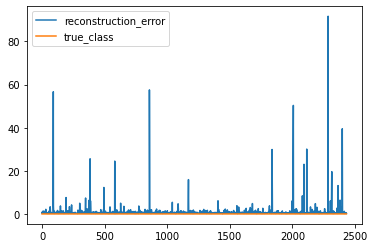

In [106]:
error_df[error_df['true_class']==0].plot()

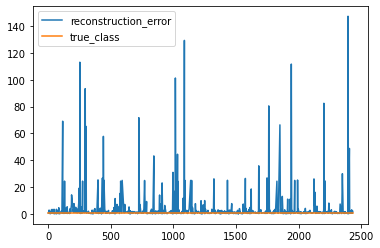

In [105]:
error_df[error_df['true_class']==1].plot()

In [144]:
error_df['true_class'].value_counts()

0    6252
Name: true_class, dtype: int64

In [148]:
x_train_orig.shape

(6252, 525)

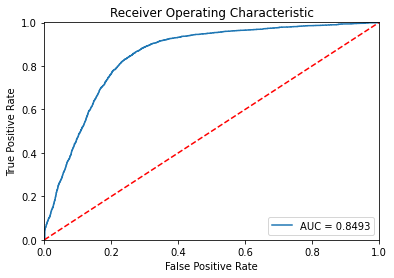

In [202]:
predictions = autoencoder.predict(x_train_orig)
mse = np.mean(np.power(x_train_orig - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_train_orig})

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

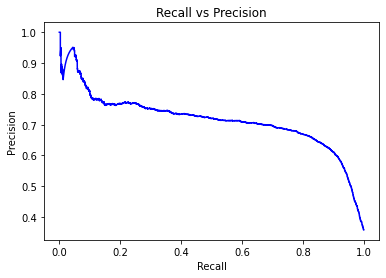

In [203]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

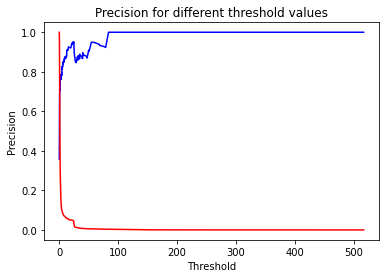

In [204]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.plot(th, recall[1:], 'r', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

In [156]:
report_metric(autoencoder_wrapper, x_train_orig, y_train_orig, x_test, y_test)

,data,user_count,threshold,optimal_threshold,roc_auc,precision,recall,f1_score,Fraud_ActualFraud,Fraud_ActualNonFraud,NonFraud_ActualFraud,NonFraud_ActualNonFraud
0,train,9732,0.96,False,0.849,0.709,0.600,0.650,2088,857,1392,5395
1,train,9732,0.81,True,0.849,0.697,0.701,0.699,2438,1062,1042,5190
0,test,2434,0.96,False,0.852,0.717,0.601,0.654,506,200,336,1392
1,test,2434,0.81,True,0.852,0.697,0.701,0.699,590,257,252,1335


In [205]:
def calculate_precision_recall(model, X, y):
    """
    calulate precision, recall based on different thresholds
    :param X: pandas dataframe
    :param y: array of labels
    :return: dataframe of model_name, precision, recall, threshold
    """
    thresh_list = []
    precision_list = []
    recall_list = []

    predd = model.predict_proba(X)
    for my_threshold in range(500, 1000, 10):
        thres = my_threshold / 1000
        y_test_pred = (predd >= thres).argmax(axis=1)

        recall1 = round(recall_score(y, y_test_pred), 2)
        prec1 = round(precision_score(y, y_test_pred), 2)
        precision_list.append(prec1)
        recall_list.append(recall1)
        thresh_list.append(thres)

    df_threshold = pd.DataFrame(
        {'precision_fraud': precision_list, 'recall_fraud': recall_list,
         'threshold': thresh_list})
    return df_threshold

def report_optimal_threshold(model, X, y):
    """
    calulate the optimal threshold for balanced precision and recall
    :param X: pandas dataframe
    :param y: array of labels
    :return: float of optimal threshold
    """
    df_threshold = calculate_precision_recall(model, X, y)
    df_threshold['diff'] = np.abs(df_threshold['precision_fraud'] - df_threshold['recall_fraud'])
    optimal_threshold = df_threshold[df_threshold['diff'] == df_threshold['diff'].min()]['threshold'].values[0]
    return optimal_threshold

def calculate_precision_threshold(model, X, y):
    df_threshold = calculate_precision_recall(model, X, y)

    predd = model.predict_proba(X)
    list_of_met = []
    for i in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98]:
        df_threshold['prec_th'] = i
        list_of_met.append(df_threshold[df_threshold['precision_fraud'] >= i][:1])

    df_met = pd.concat(list_of_met)
    conf_matrix_all = [list(report_confusion_matrix(y, predd, threshold=prec_th)) for prec_th in
                       df_met['threshold']]
    df_res = pd.DataFrame(conf_matrix_all, \
                          columns=["NonFraud_ActualNonFraud", "Fraud_ActualNonFraud", "NonFraud_ActualFraud",
                                   "Fraud_ActualFraud"])

    df_met['Fraud_ActualFraud'] = df_res['Fraud_ActualFraud'].values
    df_met['Fraud_ActualNonFraud'] = df_res['Fraud_ActualNonFraud'].values
    df_met['NonFraud_ActualFraud'] = df_res['NonFraud_ActualFraud'].values
    df_met['NonFraud_ActualNonFraud'] = df_res['NonFraud_ActualNonFraud'].values

    df_met = df_met.reset_index(drop=True)
    return df_met


def report_confusion_matrix(y, y_pred_proba, threshold=0.5):
    """
    :param y: true labels
    :param y_pred_proba: predicted probability
    :param threshold: threshold of fraud
    :return: 1d numpy array of confusion matrix
    """
    y_pred = (y_pred_proba >= threshold).argmax(axis=1)
    confusion_mat = confusion_matrix(y, y_pred).ravel()
    return confusion_mat

def report_metrics(model, X, y, optimal_threshold=None, data_name=None):
    """
    calculate confusion matrix, roc_auc, precision and recall
    :param X: dataframe ready to predcit
    :param y: true labels
    :param data_name: string name of data (train, test)
    :return:
    """
    y_pred_proba = model.predict_proba(X)
    roc_score = roc_auc_score(y, y_pred_proba[:, 1], average="weighted")

    curr_threshold = 0.96
    conf_matrix_ = list(report_confusion_matrix(y, y_pred_proba, threshold=curr_threshold))
    conf_matrix_.append(curr_threshold)
    # threshold IsOptimal
    conf_matrix_.append(False)

    if not optimal_threshold:
        optimal_threshold = report_optimal_threshold(model, X, y)
    conf_matrix_optimal_th = list(report_confusion_matrix(y, y_pred_proba, threshold=optimal_threshold))
    conf_matrix_optimal_th.append(optimal_threshold)
    # threshold IsOptimal
    conf_matrix_optimal_th.append(True)

    df_res = pd.DataFrame([conf_matrix_, conf_matrix_optimal_th], \
                          columns=["NonFraud_ActualNonFraud", "Fraud_ActualNonFraud", \
                                   "NonFraud_ActualFraud", "Fraud_ActualFraud", \
                                   "threshold", "optimal_threshold"])
    df_res['roc_auc'] = roc_score
    df_res['data'] = data_name
    df_res['user_count'] = len(y)

    df_res['precision'] = df_res['Fraud_ActualFraud'] / (
            df_res['Fraud_ActualFraud'] + df_res['Fraud_ActualNonFraud'])
    df_res['recall'] = df_res['Fraud_ActualFraud'] / (df_res['Fraud_ActualFraud'] + df_res['NonFraud_ActualFraud'])
    df_res['f1_score'] = (2 * df_res['precision'] * df_res['recall']) / (df_res['precision'] + df_res['recall'])

    df_res = round(df_res, 3)
    df_res = df_res[['data', 'user_count', 'threshold', 'optimal_threshold', \
                     'roc_auc', 'precision', 'recall', 'f1_score', \
                     'Fraud_ActualFraud', 'Fraud_ActualNonFraud', 'NonFraud_ActualFraud',
                     'NonFraud_ActualNonFraud']]
    return df_res


def report_metric(model, x_train, y_train, x_test, y_test):
    train_report = report_metrics(model, x_train, y_train, data_name='train')
    opt_t=train_report[train_report['optimal_threshold'] ==True]['threshold'].values[0]
    test_report= report_metrics(model, x_test, y_test, optimal_threshold=opt_t, data_name='test')

    report = pd.concat([train_report, test_report])
    return report

In [206]:
y_test.shape

(2434,)

In [207]:
class model_wrapper:
    def __init__(self, model):
        self._model= model
        
    def predict_proba(self, X):
        predictions = self._model.predict(X)
#         mse = np.mean(np.power(X - predictions, 2), axis=1)
        mse = np.mean(np.absolute(X - predictions), axis=1)
        return np.array(list(map(list,list(zip(1- mse.values, mse.values)))))


In [208]:

autoencoder.predict(x_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [209]:
autoencoder_wrapper = model_wrapper(autoencoder)
# autoencoder_wrapper.predict_proba(x_train)[:, 1]

In [210]:

report_metric(autoencoder_wrapper, x_train_orig, y_train_orig, x_test, y_test)

,data,user_count,threshold,optimal_threshold,roc_auc,precision,recall,f1_score,Fraud_ActualFraud,Fraud_ActualNonFraud,NonFraud_ActualFraud,NonFraud_ActualNonFraud
0,train,9732,0.96,False,0.891,0.835,0.044,0.083,152,30,3328,6222
1,train,9732,0.50,True,0.891,0.780,0.680,0.727,2367,666,1113,5586
0,test,2434,0.96,False,0.891,0.836,0.061,0.113,51,10,791,1582
1,test,2434,0.50,True,0.891,0.771,0.697,0.732,587,174,255,1418


In [201]:
np.sqrt(2)

1.4142135623730951

In [37]:
error_df.reconstruction_error

0       0.305250
1       0.797533
2       0.879412
3       1.302905
4       0.390585
          ...   
2429    0.218144
2430    0.694738
2431    0.509547
2432    0.289973
2433    2.099228
Name: reconstruction_error, Length: 2434, dtype: float64

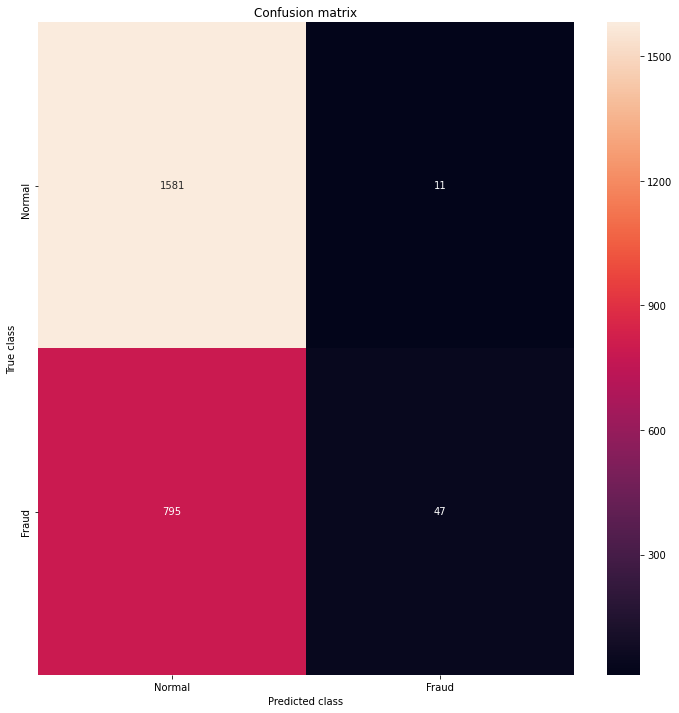

In [124]:
import seaborn as sns
LABELS = ["Normal", "Fraud"]
threshold = 19
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:


traindata = pd.read_csv('kdd/kddtrain.csv', header=None)
testdata = pd.read_csv('kdd/kddtest.csv', header=None)


X = traindata.iloc[:,1:42]
Y = traindata.iloc[:,0]
C = testdata.iloc[:,0]
T = testdata.iloc[:,1:42]

scaler = Normalizer().fit(X)
trainX = scaler.transform(X)

scaler = Normalizer().fit(T)
testT = scaler.transform(T)

y_train = np.array(Y)
y_test = np.array(C)


# reshape input to be [samples, time steps, features]
X_train = np.reshape(trainX, (trainX.shape[0],trainX.shape[1],1))
X_test = np.reshape(testT, (testT.shape[0],testT.shape[1],1))




lstm_output_size = 128

cnn = Sequential()
cnn.add(Convolution1D(64, 3, border_mode="same",activation="relu",input_shape=(41, 1)))
cnn.add(MaxPooling1D(pool_length=(2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation="sigmoid"))
print(cnn.summary())
# define optimizer and objective, compile cnn

'''
cnn.compile(loss="binary_crossentropy", optimizer="adam",metrics=['accuracy'])

# train
checkpointer = callbacks.ModelCheckpoint(filepath="results/cnn1results/checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
csv_logger = CSVLogger('results/cnn1results/cnntrainanalysis1.csv',separator=',', append=False)
cnn.fit(X_train, y_train, nb_epoch=1000, show_accuracy=True,validation_data=(X_test, y_test),callbacks=[checkpointer,csv_logger])
cnn.save("results/cnn1results/cnn_model.hdf5")
'''
